In [1]:
#!pip3 install torch==1.10.0+cu102 torchvision==0.11.1+cu102 torchaudio===0.10.0+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html

In [2]:
import torch 
import torch.nn as nn
import torchvision

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math
import os
from sklearn.model_selection import train_test_split

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
batch_size = 32 #64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

path = 'CovidData/'
#path = '/content/drive/Shareddrives/MachineLearning/CovidData/'

train_set = torchvision.datasets.ImageFolder(root=path+'train', transform = transforms.ToTensor())
val_set = torchvision.datasets.ImageFolder(root=path+'valid', transform = transforms.ToTensor())
test_set = torchvision.datasets.ImageFolder(root=path+'test', transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

print(len(train_set))
print(len(val_set))
print(len(test_set))

cuda:0
14818
4232
2115


In [5]:
#hypengrparameter 
num_classes = 4
learning_rate =  0.001
num_epochs = 20

class CNN3(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=2), #(299+2*2-3)/1+1 = 301
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #301/2=150.5 = 150
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), #(150+2*2-5)/1+1 = 150
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #150/2 = 75
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), #(75+2*2-5)/1+1 = 75          
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #75/2 = 37
        self.fc = nn.Linear(37*37*64, num_classes) #Aplica una transformación lineal: y=xA.T + b
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
model         = CNN3(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

print([ e.shape  for e in model.fc.parameters()])

model.fc.weight

[torch.Size([4, 87616]), torch.Size([4])]


Parameter containing:
tensor([[-2.6579e-03,  1.6785e-03,  7.0834e-04,  ...,  3.1906e-03,
         -2.0430e-03,  2.7863e-04],
        [ 1.6357e-03,  2.6634e-03,  1.0306e-03,  ...,  3.0385e-03,
          1.6760e-03, -9.8733e-04],
        [-2.4321e-03,  1.6602e-03,  2.4208e-03,  ...,  1.7446e-03,
         -1.0026e-03,  2.3141e-03],
        [ 2.9190e-03, -2.8095e-03,  9.5696e-05,  ..., -4.6546e-04,
          1.1351e-03, -1.0440e-03]], device='cuda:0', requires_grad=True)

In [7]:
def train(model, optimizer, loos_fn, num_epochs):
  loss_vals = []
  running_loss =0.0
  # train the model
  total_step = len(train_loader)  # el train loader es el motor que se encarga de sacar las imagenes del train_set

  list_loss= []
  list_time = []
  list_loss_val = []
  j=0

  for epoch in range(num_epochs):
    k=0
    for i, (images, labels) in enumerate(train_loader):
    #for i in range(50):

      #images = train_loader[i][0].to(device)
      #labels = train_loader[i][1].to(device)

      images = images.to(device)
      labels = labels.to(device)
      
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      list_loss.append(loss.item())
      list_time.append(j)
      j+=1
              
      if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
      k+=1
      #if (k == 1000):
      #  break 
  print('Finished Training Trainset')
  return list_loss


In [8]:
train_loss = train(model,optimizer,loss_fn,5)

Epoch [1/5], Step [100/464], Loss: 1.8884
Epoch [1/5], Step [200/464], Loss: 0.4492
Epoch [1/5], Step [300/464], Loss: 0.8001
Epoch [1/5], Step [400/464], Loss: 0.5800
Epoch [2/5], Step [100/464], Loss: 0.5636
Epoch [2/5], Step [200/464], Loss: 0.4056
Epoch [2/5], Step [300/464], Loss: 0.4674
Epoch [2/5], Step [400/464], Loss: 0.4499
Epoch [3/5], Step [100/464], Loss: 0.3561
Epoch [3/5], Step [200/464], Loss: 0.5415
Epoch [3/5], Step [300/464], Loss: 0.5567
Epoch [3/5], Step [400/464], Loss: 0.5970
Epoch [4/5], Step [100/464], Loss: 0.5060
Epoch [4/5], Step [200/464], Loss: 0.4058
Epoch [4/5], Step [300/464], Loss: 0.3973
Epoch [4/5], Step [400/464], Loss: 0.3249
Epoch [5/5], Step [100/464], Loss: 0.2917
Epoch [5/5], Step [200/464], Loss: 0.6807
Epoch [5/5], Step [300/464], Loss: 0.2433
Epoch [5/5], Step [400/464], Loss: 0.3428
Finished Training Trainset


Text(0.5, 1.0, 'Training Error: BatchNorm+Dropout en la ultima Capa')

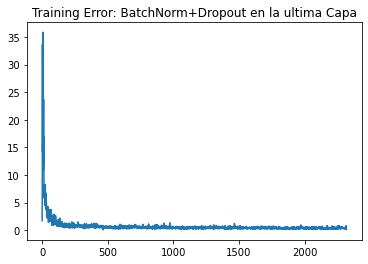

In [9]:
plt.plot(train_loss)
plt.title("Training Error: BatchNorm+Dropout en la ultima Capa")

In [10]:
#Precision con el set de validación (20%).
with torch.no_grad():
      correct = 0
      total = 0
      k=0
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          #k+=1
          #if (k == 100):
          #  break
      print('Validation Accuracy of the model: {} %'.format(100 * correct / total))

Validation Accuracy of the model: 85.27882797731569 %


In [11]:
#Precision con el set de test (10%).
with torch.no_grad():
      correct = 0
      total = 0
      k=0
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          #k+=1
          #if (k == 100):
          #  break
      print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 85.48463356973996 %
